# Assignment 2 - Oğulcan ÖZDEMİR 2015700093

## Question 1 - Importance Sampling

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

np.set_printoptions(precision=4)

In [6]:
sigma = np.array([[1, 0], 
                  [0, 1]])
mu = np.zeros(2);

# proposal
q = lambda x: (1/(2*np.pi*np.sqrt(np.linalg.det(sigma))))*np.exp(-0.5*np.matrix(x-mu)*np.linalg.inv(sigma)*np.matrix(x-mu).T)

def p_norm(x, y, p):
    return np.power(np.absolute(x), p) + np.power(np.absolute(y), p)

def calculate_area_of_pnorm_ball(p, nSamples):
    x, y = np.random.multivariate_normal(mu, sigma, nSamples).T    
    
    # discard samples where pnorm of x and y less than or equal to 1 
    idx = p_norm(x, y, p) <= 1
    v = np.column_stack((x[idx], y[idx]))

    # compute weights
    qv = [q(v[i]) for i in range(0,len(v))]
    weights = [1.0 / qv[i] for i in range(0, len(qv))]

    return np.sum(weights)/N

# calculate area for c=20 times
def runEstimation(c, p):
    area = np.zeros(c);
    for i in range(0, c):
        area[i] = calculate_area_of_pnorm_ball(p, N)

    variance = np.var(area)
    avg_area = np.mean(area)
    if p % 0.5 == 0:
        print('(p : %.1f) => Variance : %f, Area %f' % (p, variance, avg_area))        
    return variance, avg_area

N = 1000
c = 20
p = np.linspace(0.5, 2, 4)
for i in range(0, len(p)):
    runEstimation(c, p[i])

(p : 0.5) => Variance : 0.002878, Area 0.703835
(p : 1.0) => Variance : 0.013847, Area 2.036339
(p : 1.5) => Variance : 0.004266, Area 2.704825
(p : 2.0) => Variance : 0.015281, Area 3.136386


## Question 2

#### a) Transition Matrix

In [7]:
A = np.array([[1/4, 1/4, 1/4, 1/4, 1/4, 1/4],
              [  0, 1/4,   0,   0, 1/4,   0],
              [  0,   0,   0, 1/2,   0,   0],
              [1/4, 1/4, 1/2,   0, 1/4, 1/4],
              [1/4, 1/4, 1/4, 1/4, 1/4, 1/4],
              [1/4,   0,   0,   0,   0, 1/4]])
print(A)

[[ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.5   0.    0.  ]
 [ 0.25  0.25  0.5   0.    0.25  0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.    0.    0.    0.    0.25]]


#### b) Stationary Matrix by computing eigenvalues and eigen vectors

The stationary distribution is not a uniform distribution.

In [8]:
eVal, eVec = sp.linalg.eig(A)
sta_dist = np.real_if_close(eVec[:, np.argmax(np.isclose(eVal, 1.0))], tol=0)
sta_dist = sta_dist / sum(sta_dist)
print(sta_dist)

[ 0.25    0.0833  0.1111  0.2222  0.25    0.0833]


#### c) Detailed Balance Condition

In [9]:
x = np.dot(A, np.diag(sta_dist))
print(x)
np.allclose(x, x.transpose())

[[ 0.0625  0.0208  0.0278  0.0556  0.0625  0.0208]
 [ 0.      0.0208  0.      0.      0.0625  0.    ]
 [ 0.      0.      0.      0.1111  0.      0.    ]
 [ 0.0625  0.0208  0.0556  0.      0.0625  0.0208]
 [ 0.0625  0.0208  0.0278  0.0556  0.0625  0.0208]
 [ 0.0625  0.      0.      0.      0.      0.0208]]


False

#### d) $T_{mix}$


In [10]:
def get_mixing_time(sta_dist, eps=1e-8):
    pi_t = np.array([1, 0, 0, 0, 0, 0]) # starts from 1
    mixTime = 0
    mixData = pi_t
    
    # loop until total variation distance between pi_t and stationary distribution
    # is lower than epsilon threshold
    while (0.5*np.linalg.norm(pi_t - sta_dist, 1)) > eps:
        pi_t = A.dot(pi_t)
        mixData = np.column_stack((mixData, pi_t))
        mixTime += 1
    
    return mixTime, mixData
    
mixTime,_ = get_mixing_time(sta_dist)
print("T_mix = %d " % mixTime)

T_mix = 24 


#### e) 
Powers of A

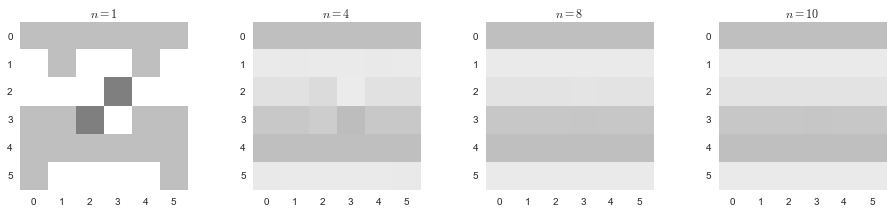

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
for i, n in enumerate([1, 4, 8, 10]):
    ax[i].imshow(np.linalg.matrix_power(A, n), vmin = 0, vmax = 1, interpolation='nearest', cmap=plt.cm.gray_r)
    ax[i].set_title("$n = %d$" % n)
    ax[i].grid(False)

Changes of $\pi$ 

Mixing time = 24 


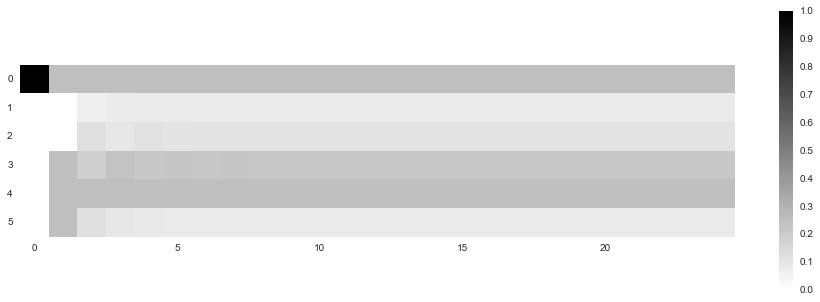

In [12]:
mixTime, mixData = get_mixing_time(sta_dist)
print("Mixing time = %d " % mixTime)
plt.figure(figsize=(16, 5))
#sns.heatmap(mixData, cmap='Greys')

plt.imshow(mixData, cmap=plt.cm.gray_r,  interpolation='nearest')
plt.grid(False)
plt.colorbar()

#### f) Draw Independent Samples

In [13]:
def run_chain(A, N):
    chain = np.zeros(N).astype(int)
    for i in range(1, N):
        chain[i] = np.random.choice(range(6), p = A[:, chain[i-1]])

    return chain

print(run_chain(A, mixTime))

[0 4 0 0 3 0 4 3 4 3 0 3 2 4 1 3 4 1 0 3 0 3 0 3]


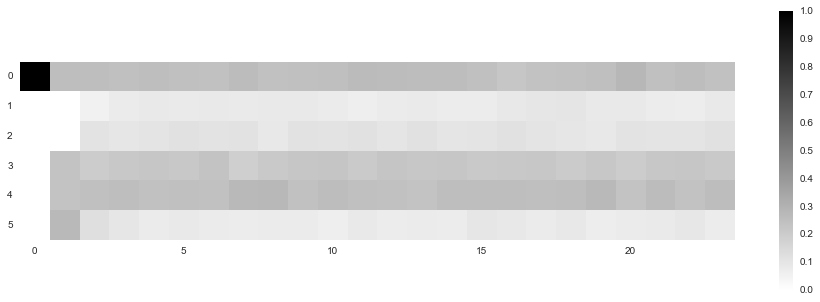

In [14]:
N = 1000
trajectory = np.zeros(shape=(N, mixTime))

for i in range(N):
    chain = run_chain(A, mixTime)
    trajectory[i, :] = chain
    
histogram = np.apply_along_axis(lambda x: np.histogram(x, bins=[0,1,2,3,4,5,6], density = True)[0], 0, trajectory)
plt.figure(figsize=(16, 5))
plt.imshow(histogram, cmap=plt.cm.gray_r,  interpolation='nearest')
plt.grid(False)
plt.colorbar()

#### g) 

Sample:      [ 0.26   0.068  0.126  0.228  0.235  0.083]
Stationary:  [ 0.25    0.0833  0.1111  0.2222  0.25    0.0833]


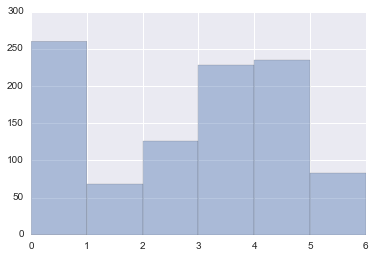

In [15]:
chain = run_chain(A, N + mixTime)[mixTime::]
sns.distplot(chain, kde = False, bins = [0,1,2,3,4,5,6])
c,_ = np.histogram(chain, bins=[0,1,2,3,4,5,6], density=True);
print('Sample:     ', c)
print('Stationary: ', sta_dist)